## Rappel Google Colab

Tout d'abord, sélectionnez l'option GPU de Colab avec *Edit > Notebook settings* et sélectionner GPU comme Hardware accelerator. 
Installer ensuite deeplib avec la commande suivante:

In [ ]:
!pip install git+https://github.com/ulaval-damas/glo4030-labs.git

# Laboratoire 4: Régularisation

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import math
import poutyne as pt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from deeplib.datasets import load_cifar10, load_mnist, train_valid_loaders
from deeplib.net import CifarNet, CifarNetBatchNorm
from deeplib.training import train, test

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 150

cifar_train, cifar_test = load_cifar10()
mnist_train, mnist_test = load_mnist()

Files already downloaded and verified
Files already downloaded and verified


## Partie 1: Régularisation L1 et L2

### Implémentation manuelle
Dans la communauté de l'apprentissage profond, la régularisation L2 est communément appelée **weight decay**. Dans PyTorch, les optimiseurs de `torch.optim` ont un paramètre `weight_decay` pour utiliser cette régularisation. Par contre, on peut facilement implémenter manuellement la régularisation L2 comme une pénalité sur la norme des poids (voir le [chapitre 7.1](http://www.deeplearningbook.org/contents/regularization.html)).

#### Exercice
 - Complétez la fonction *loss_init* en ajoutant manuellement la pénalité sur les paramètres du réseau selon une régularisation L1 ou L2. Le paramètre *reg_alpha* correspond à l'hyperparamètre de régularisation $\alpha$ du livre ($\lambda$ dans les acétates du cours). Le paramètre *p* correspond à l'ordre de la norme: $p=1$ pour la norme L1 et $p=2$ pour la norme L2.

In [2]:
def loss_init(parameters=[], reg_alpha=0, p=2):
    cross_entropy = nn.CrossEntropyLoss()
    
    def loss_function(output, targets):
        loss = cross_entropy(output,targets)

        for param in parameters:
            # TODO
            # Solution version 1
            loss += reg_alpha/p * torch.norm(param, p=p) ** p
            
            '''
            # Solution version 2
            # Norme L1
            if p == 1:
                loss += reg_alpha * torch.abs(param).sum()
            
            # Norme L2
            elif p == 2:
                loss += reg_alpha * 1/2 * torch.pow(param, 2).sum()
            '''
        
        return loss
    return loss_function

Testez votre implémentation de la régularisation par la norme L2 ($p=2$):

In [3]:
torch.manual_seed(42)
net = CifarNet()

optimizer = optim.SGD(net.parameters(), lr=0.1)
loss = loss_init(list(net.parameters()), reg_alpha=1e-3, p=2)

history = train(net, optimizer, cifar_train, n_epoch=5, batch_size=64, use_gpu=True, criterion=loss)

Epoch: 1/5 Step: 625/625 100.00% |█████████████████████████|9.92s loss: 1.962845 acc: 30.370000 val_loss: 1.600946 val_acc: 44.570000
Epoch: 2/5 Step: 625/625 100.00% |█████████████████████████|9.96s loss: 1.489838 acc: 48.570000 val_loss: 1.362047 val_acc: 54.340000
Epoch: 3/5 Step: 625/625 100.00% |█████████████████████████|9.80s loss: 1.309842 acc: 56.230000 val_loss: 1.274933 val_acc: 57.650000
Epoch: 4/5 Step: 625/625 100.00% |█████████████████████████|9.94s loss: 1.173771 acc: 61.935000 val_loss: 1.188769 val_acc: 61.620000
Epoch: 5/5 Step: 625/625 100.00% |█████████████████████████|9.83s loss: 1.076642 acc: 66.147500 val_loss: 1.091546 val_acc: 66.090000


Testez votre implémentation de la régularisation par la norme L1 ($p=1$):

In [4]:
torch.manual_seed(42)
net = CifarNet()
optimizer = optim.SGD(net.parameters(), lr=0.1)
loss = loss_init(list(net.parameters()), reg_alpha=1e-3, p=1)

history = train(net, optimizer, cifar_train, n_epoch=5, batch_size=64, use_gpu=True, criterion=loss)

Epoch: 1/5 Step: 625/625 100.00% |█████████████████████████|9.01s loss: 2.775981 acc: 20.697500 val_loss: 2.136849 val_acc: 27.580000
Epoch: 2/5 Step: 625/625 100.00% |█████████████████████████|9.61s loss: 2.085503 acc: 27.610000 val_loss: 2.008948 val_acc: 30.710000
Epoch: 3/5 Step: 625/625 100.00% |█████████████████████████|9.78s loss: 2.021104 acc: 30.185000 val_loss: 1.939987 val_acc: 32.550000
Epoch: 4/5 Step: 625/625 100.00% |█████████████████████████|9.20s loss: 1.896943 acc: 36.100000 val_loss: 1.892167 val_acc: 36.930000
Epoch: 5/5 Step: 625/625 100.00% |█████████████████████████|9.03s loss: 1.836869 acc: 38.420000 val_loss: 1.783151 val_acc: 40.030000


### Utilisation du *weight decay*

Explorons maintenant l'utilisation du paramètre `weight_decay` disponible dans les optimiseurs de `PyTorch` pour effectuer de la régularisation L2. Nous allons entrainer un réseau de neurones avec régularisation L2 et un autre sans pour pouvoir observer l'impact de la régularisation sur l'apprentissage et le réseau appris.

In [5]:
# Paramètres
batch_size = 64
lr = 0.1
n_epoch = 15

Réseau sans régularisation L2:

Epoch: 1/15 Step: 625/625 100.00% |█████████████████████████|6.87s loss: 1.916432 acc: 30.947500 val_loss: 1.526754 val_acc: 45.710000
Epoch: 2/15 Step: 625/625 100.00% |█████████████████████████|6.38s loss: 1.415215 acc: 49.407500 val_loss: 1.283624 val_acc: 54.750000
Epoch: 3/15 Step: 625/625 100.00% |█████████████████████████|6.81s loss: 1.208318 acc: 57.487500 val_loss: 1.158787 val_acc: 59.280000
Epoch: 4/15 Step: 625/625 100.00% |█████████████████████████|6.85s loss: 1.045378 acc: 63.620000 val_loss: 1.050210 val_acc: 63.610000
Epoch: 5/15 Step: 625/625 100.00% |█████████████████████████|7.00s loss: 0.923764 acc: 67.977500 val_loss: 0.958788 val_acc: 67.230000
Epoch: 6/15 Step: 625/625 100.00% |█████████████████████████|7.10s loss: 0.816356 acc: 71.665000 val_loss: 0.983069 val_acc: 66.000000
Epoch: 7/15 Step: 625/625 100.00% |█████████████████████████|6.91s loss: 0.726198 acc: 74.677500 val_loss: 0.916011 val_acc: 68.670000
Epoch: 8/15 Step: 625/625 100.00% |████████████████████

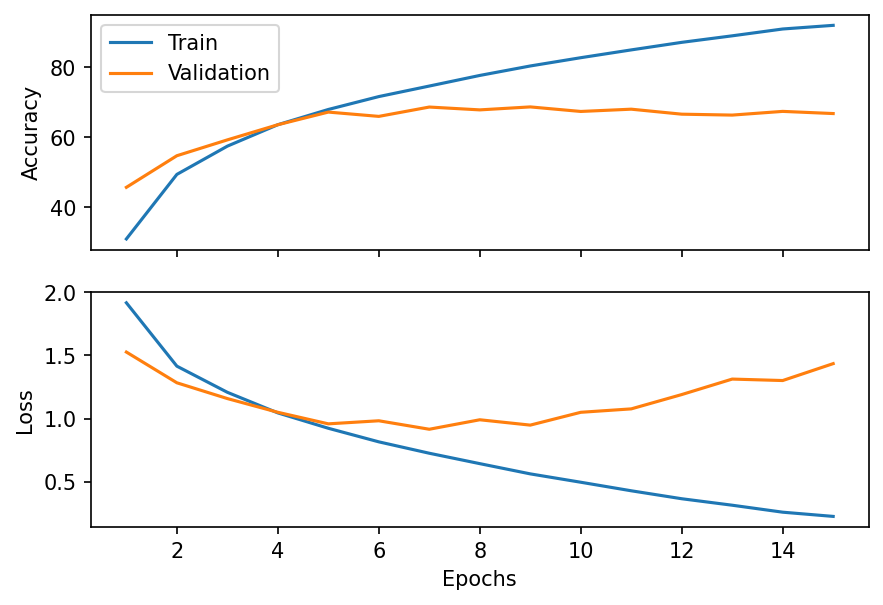

Précision en test: 66.57


In [6]:
torch.manual_seed(42)
net_without_l2 = CifarNet()
optimizer_without_l2 = optim.SGD(net_without_l2.parameters(), lr=lr, weight_decay=0)

history_without_l2 = train(net_without_l2, optimizer_without_l2, cifar_train, n_epoch, batch_size, use_gpu=True)
history_without_l2.display()
print('Précision en test: {:.2f}'.format(test(net_without_l2, cifar_test, batch_size)))

Réseau avec régularisation L2 (*weight decay*):

Epoch: 1/15 Step: 625/625 100.00% |█████████████████████████|6.57s loss: 1.933677 acc: 30.137500 val_loss: 1.563158 val_acc: 43.920000
Epoch: 2/15 Step: 625/625 100.00% |█████████████████████████|7.23s loss: 1.438792 acc: 48.347500 val_loss: 1.298024 val_acc: 54.440000
Epoch: 3/15 Step: 625/625 100.00% |█████████████████████████|6.99s loss: 1.235591 acc: 56.510000 val_loss: 1.188892 val_acc: 57.960000
Epoch: 4/15 Step: 625/625 100.00% |█████████████████████████|6.92s loss: 1.079636 acc: 62.277500 val_loss: 1.077926 val_acc: 62.190000
Epoch: 5/15 Step: 625/625 100.00% |█████████████████████████|6.56s loss: 0.964891 acc: 66.407500 val_loss: 0.968593 val_acc: 66.810000
Epoch: 6/15 Step: 625/625 100.00% |█████████████████████████|7.36s loss: 0.869296 acc: 69.780000 val_loss: 0.967457 val_acc: 66.290000
Epoch: 7/15 Step: 625/625 100.00% |█████████████████████████|6.91s loss: 0.793289 acc: 72.685000 val_loss: 0.935862 val_acc: 67.650000
Epoch: 8/15 Step: 625/625 100.00% |████████████████████

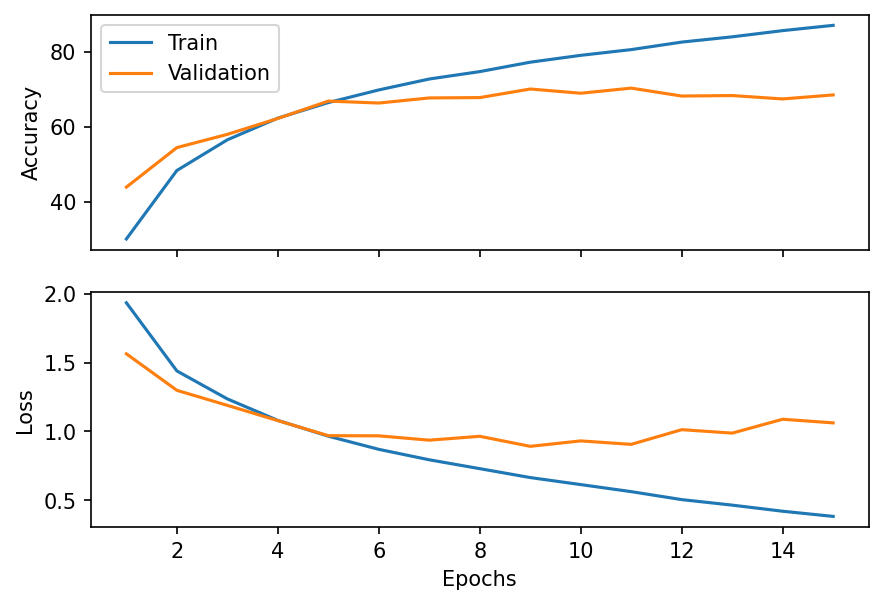

Précision en test: 68.75


In [7]:
weight_decay = 1e-3

torch.manual_seed(42)
net_l2 = CifarNet()
optimizer_l2 = optim.SGD(net_l2.parameters(), lr=lr, weight_decay=weight_decay)

history_l2 = train(net_l2, optimizer_l2, cifar_train, n_epoch, batch_size, use_gpu=True)
history_l2.display()
print('Précision en test: {:.2f}'.format(test(net_l2, cifar_test, batch_size)))

#### Questions
- Quel est l'effet de la régularisation L2 sur l'entraînement du réseau? 

    **Au niveau de l'accuracy, on remarque que les performances en validation et en test sont légèrement meilleures. Également, l'utilisation de la régularisation réduit le surapprentissage. En effet l'écart des valeurs d'accuracy et de loss entre l'entraînement et la validation est nettement moins important (voir graphiques)**
    
- Si vous utilisez un `weight_decay` trop grand (exemple 0.1) qu'arrive-t-il? Pourquoi? 
    **Le réseau ne parvient tout simplement pas à apprendre, car la pénalité sur les poids est trop importante.**

Dans la cellule suivante, analysez avec un histogramme la distribution des poids appris par les réseaux avec ou sans régularisation. 

- Que remarquez-vous? 

    **Avec la régularisation L2, les poids appris sont plus concentrés près de 0.**
    
- Essayez d'autres valeurs de weight decay (1e-2, 1e-4) et observez l'impact sur la distribution des poids appris. 
    
    **Plus le weight decay est élevé (1e-2), plus la distribution des poids se resserre autour de zéro. À l'opposé, plus le weight decay est faible (1e-4), plus la distribution des poids régularisés ressemble à la distribution des poids appris sans régularisation**

Poids sans régularisation L2: variance 0.0057, maximum 1.6754.
Poids avec régularisation L2: variance 0.0031, maximum 1.4089.


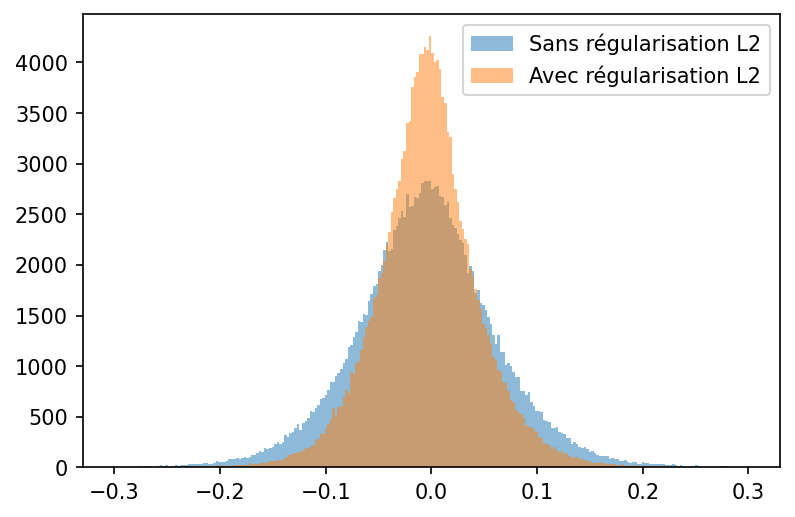

In [8]:
def net_to_weight_array(net):
    weights = []
    for p in net.parameters():
        p_numpy = p.data.cpu().numpy()
        weights.append(p_numpy.reshape((-1))) # Reshape to 1D array
    return np.concatenate(weights)

weights_without_l2 = net_to_weight_array(net_without_l2)
weights_l2 = net_to_weight_array(net_l2)

print("Poids sans régularisation L2: variance {:.4f}, maximum {:.4f}.".format(np.var(weights_without_l2), 
                                                                              np.max(np.abs(weights_without_l2))))
print("Poids avec régularisation L2: variance {:.4f}, maximum {:.4f}.".format(np.var(weights_l2), 
                                                                              np.max(np.abs(weights_l2))))

# Visualisation
plt.hist(weights_without_l2, bins=250, range=(-0.3, 0.3), alpha =0.5, label="Sans régularisation L2")
plt.hist(weights_l2, bins=250, range=(-0.3, 0.3), alpha=0.5, label="Avec régularisation L2")
plt.legend()
plt.show()

## Partie 2: Early stopping

Commencez par entraîner un réseau pour un grand nombre d'époques. L'historique d'entraînement nous servira de base pour les questions qui suivent.

In [9]:
torch.manual_seed(42)
net = CifarNetBatchNorm()

optimizer = optim.SGD(net.parameters(), lr=0.01, weight_decay=1e-3, nesterov=True, momentum=0.9)
scheduler = pt.ReduceLROnPlateau(monitor='val_acc', mode='max', patience=3, factor=0.5, verbose=True)

history = train(net, optimizer, cifar_train, n_epoch=40, batch_size=64, callbacks=[scheduler], use_gpu=True)

Epoch: 1/40 Step: 625/625 100.00% |█████████████████████████|7.43s loss: 1.586192 acc: 45.580000 val_loss: 1.315081 val_acc: 52.230000
Epoch: 2/40 Step: 625/625 100.00% |█████████████████████████|7.83s loss: 1.179938 acc: 58.022500 val_loss: 1.208588 val_acc: 56.950000
Epoch: 3/40 Step: 625/625 100.00% |█████████████████████████|7.83s loss: 0.999717 acc: 64.737500 val_loss: 1.136691 val_acc: 60.460000
Epoch: 4/40 Step: 625/625 100.00% |█████████████████████████|8.63s loss: 0.871303 acc: 69.787500 val_loss: 1.054519 val_acc: 63.090000
Epoch: 5/40 Step: 625/625 100.00% |█████████████████████████|8.18s loss: 0.783967 acc: 72.862500 val_loss: 1.055590 val_acc: 64.050000
Epoch: 6/40 Step: 625/625 100.00% |█████████████████████████|8.22s loss: 0.714513 acc: 75.397500 val_loss: 0.957732 val_acc: 65.920000
Epoch: 7/40 Step: 625/625 100.00% |█████████████████████████|8.26s loss: 0.652743 acc: 77.435000 val_loss: 0.960393 val_acc: 67.230000
Epoch: 8/40 Step: 625/625 100.00% |████████████████████

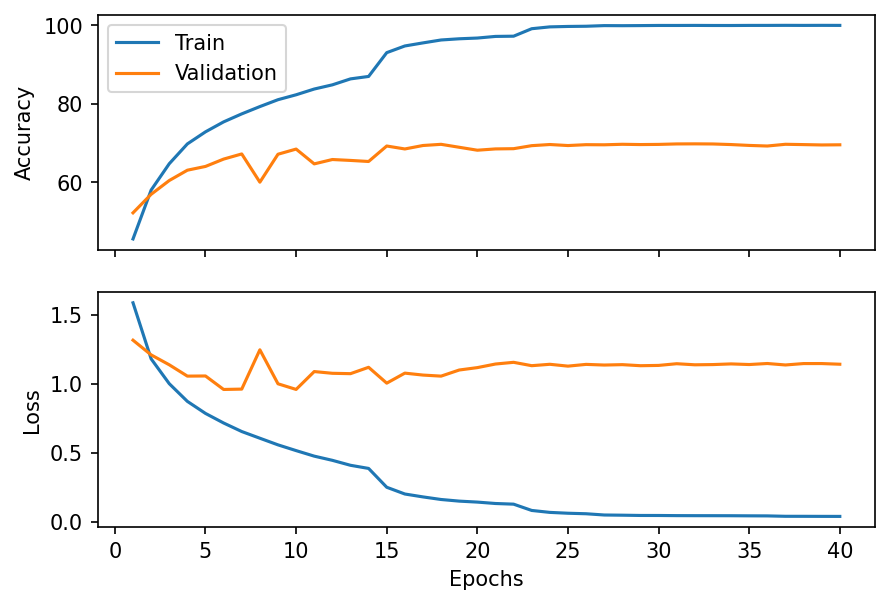

In [10]:
history.display()

#### Question
- En regardant les graphiques ci-dessus, quel est le meilleur moment pour arrêter l'entraînement? 

    **Autour de l'époque 20 la précision en validation semble la plus élevée et commence à être stable.**

L'algorithme 7.1 du livre (voir http://www.deeplearningbook.org/contents/regularization.html page 244) décrit le paramètre de patience `p` dans le contexte d'un algorithme de *early stopping* (**Attention**: le paramètre de patience `p` du *early stopping* n'a pas de lien avec le paramètre `p` correspondant à l'ordre d'une norme de la section précédente).

#### Exercice
- Analysez l'effet du choix de `p` sur les données de l'entraînement précédent. Regardez pour `p = 1,2,5,10,15`, quelle époque avec quelle précision en validation est choisie. Implémentez un algorithme effectuant du *early stopping* en utilisant l'historique `val_accuracy` de l'entraînement que vous venez d'exécuter pour vos tests (à la place d'entraîner le réseau).

In [11]:
# Historique
val_accuracy_history = history.history['val_acc']

# Patience
p = 5

best_val_accuracy = -np.inf
best_epoch = -1

# TODO
counter = 0
for epoch, val_accuracy in enumerate(val_accuracy_history):
    # Amélioration de la précision en validation
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_epoch = epoch
        counter = 0
    # On patiente ...
    else:
        counter += 1
        if counter == p:
            break
# TODO END
            
print("Pour patience p={}, la meilleure époque est {}, avec précision en validation de {:.2f}.".format(p, best_epoch, best_val_accuracy))

Pour patience p=5, la meilleure époque est 17, avec précision en validation de 69.68.


#### Question

- Identifiez des problèmes pratiques potentiels lors de l'utilisation du *early stopping*. 

    **Il est difficile de sélectionner la bonne valeur de patience. Une valeur trop faible arrête l'entraînement trop tôt ce qui peut résulter en un modèle avec de moins bonnes performances, alors qu'une valeur trop élevée de patience peut nous obliger à calculer un nombre d'époques plus important que nécessaire (temps)**

### Pour aller plus loin sur le early stopping
Avec Poutyne, on peut effectuer le *early stopping* automatiquement grâce au callback [EarlyStopping](https://poutyne.org/callbacks.html#poutyne.EarlyStopping). Il faut spécifier la métrique à monitorer ainsi que la patience, et on peut également contrôler l'amplitude minimum d'un changement pour que celui-ci soit qualifié comme une amélioration avec le paramètre `min_delta`. L'entraînement va donc s'arrêter automatiquement lorsqu'il n'y a plus d'amélioration pour un nombre consécutif d'époques correspondant à la patience, prévenant possiblement le calcul inutile de plusieurs époques.

In [12]:
# Patience
p = 3

torch.manual_seed(42)
net = CifarNetBatchNorm()

optimizer = optim.SGD(net.parameters(), lr=0.01, weight_decay=1e-3, nesterov=True, momentum=0.9)
scheduler = pt.ReduceLROnPlateau(monitor='val_acc', mode='max', patience=3, factor=0.5, verbose=True)

# Early stopping sous la forme d'un Callback
early_stopping = pt.EarlyStopping(monitor='val_acc', mode='max', min_delta=1e-5, patience=p, verbose=True)

history = train(net, optimizer, cifar_train, n_epoch=40, batch_size=64, callbacks=[scheduler, early_stopping], use_gpu=True)

Epoch: 1/40 Step: 625/625 100.00% |█████████████████████████|8.69s loss: 1.581868 acc: 45.765000 val_loss: 1.323265 val_acc: 52.670000
Epoch: 2/40 Step: 625/625 100.00% |█████████████████████████|8.32s loss: 1.169490 acc: 58.462500 val_loss: 1.173223 val_acc: 59.040000
Epoch: 3/40 Step: 625/625 100.00% |█████████████████████████|7.94s loss: 0.989927 acc: 65.142500 val_loss: 1.199262 val_acc: 58.300000
Epoch: 4/40 Step: 625/625 100.00% |█████████████████████████|7.90s loss: 0.865253 acc: 70.000000 val_loss: 0.999930 val_acc: 64.760000
Epoch: 5/40 Step: 625/625 100.00% |█████████████████████████|7.79s loss: 0.781436 acc: 72.910000 val_loss: 1.052080 val_acc: 63.310000
Epoch: 6/40 Step: 625/625 100.00% |█████████████████████████|8.18s loss: 0.710091 acc: 75.440000 val_loss: 0.988954 val_acc: 65.860000
Epoch: 7/40 Step: 625/625 100.00% |█████████████████████████|7.79s loss: 0.650509 acc: 77.537500 val_loss: 0.959956 val_acc: 67.390000
Epoch: 8/40 Step: 625/625 100.00% |████████████████████

## Partie 3: Dropout
Cette section a pour but d'analyser l'effet du dropout dans un réseau fully connected. Nous ferons cette analyse en reprenant l'exercice du laboratoire 2.

#### Exercice
- Dans le réseau suivant, implémentez la fonction `forward()` formée de couches linéaires suivies d'activation   `Relu` en ajoutant du dropout ([Indice](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.dropout)) après l'activation si `self.use_dropout == True` . Utilisez une probabilité de dropout de `0.3` indiqué par `self.dropout_p` et ne faites pas de dropout sur la couche de sortie. N'ajoutez **pas de softmax** car la fonction `deeplib.training.train()` utilise par défaut `CrossEntropyLoss`, ce qui le fait pour vous. 

> **ATTENTION!** Vous devez bien fixer l'argument `training` de dropout. Vous pouvez savoir si modèle est en entraînement ou en évaluation avec `self.training`.

In [13]:
class MnistModel(torch.nn.Module):
    
    def __init__(self, n_layers, hidden_size=100, use_dropout=True, dropout_p=0.3):
        super().__init__()
        torch.manual_seed(42)
        self.use_dropout = use_dropout
        self.hidden_size = hidden_size
        self.dropout_p = dropout_p
        
        # Initialisation des couches
        layer_sizes = [28*28] + [self.hidden_size]*n_layers
        self.layers = nn.ModuleList()
        for input_size, output_size in zip(layer_sizes[:-1], layer_sizes[1:]):
            layer = nn.Linear(input_size, output_size)
            layer.weight.data.normal_(0.0, math.sqrt(2 / input_size))
            layer.bias.data.fill_(0)
            self.layers.append(layer)
            
        
        # Couche de sortie avec une neurone par classe
        self.output_layer = nn.Linear(hidden_size,10)
        self.output_layer.weight.data.normal_(0.0, math.sqrt(2 / hidden_size))
        self.output_layer.bias.data.fill_(0)              

    def forward(self, x):
        out = x.view(-1, 28*28)
        for layer in self.layers:
            # TODO
            out = layer(out)
            out = torch.relu(out)
            if self.use_dropout:
                out = F.dropout(out, self.dropout_p, training=self.training)
            # TODO END
        return self.output_layer(out)

#### Question
- Quelle est l'importance de l'argument `training` de la fonction de dropout? 

    **Il permet d'appliquer le dropout seulement lorsqu'on entraine le réseau.**

Entraînez un réseau avec dropout et un réseau sans dropout.

In [14]:
# Paramètres
lr = 0.01
batch_size = 64
n_epoch = 20

Réseau sans dropout:

Epoch: 1/20 Step: 750/750 100.00% |█████████████████████████|6.12s loss: 0.373826 acc: 89.047917 val_loss: 0.218013 val_acc: 93.408333
Epoch: 2/20 Step: 750/750 100.00% |█████████████████████████|5.76s loss: 0.170625 acc: 94.983333 val_loss: 0.150999 val_acc: 95.383333
Epoch: 3/20 Step: 750/750 100.00% |█████████████████████████|6.30s loss: 0.124482 acc: 96.291667 val_loss: 0.127382 val_acc: 96.275000
Epoch: 4/20 Step: 750/750 100.00% |█████████████████████████|5.78s loss: 0.097827 acc: 97.075000 val_loss: 0.123656 val_acc: 96.191667
Epoch: 5/20 Step: 750/750 100.00% |█████████████████████████|5.19s loss: 0.080754 acc: 97.562500 val_loss: 0.111923 val_acc: 96.800000
Epoch: 6/20 Step: 750/750 100.00% |█████████████████████████|5.46s loss: 0.067433 acc: 97.954167 val_loss: 0.104890 val_acc: 96.750000
Epoch: 7/20 Step: 750/750 100.00% |█████████████████████████|5.79s loss: 0.057806 acc: 98.264583 val_loss: 0.097717 val_acc: 96.966667
Epoch: 8/20 Step: 750/750 100.00% |████████████████████

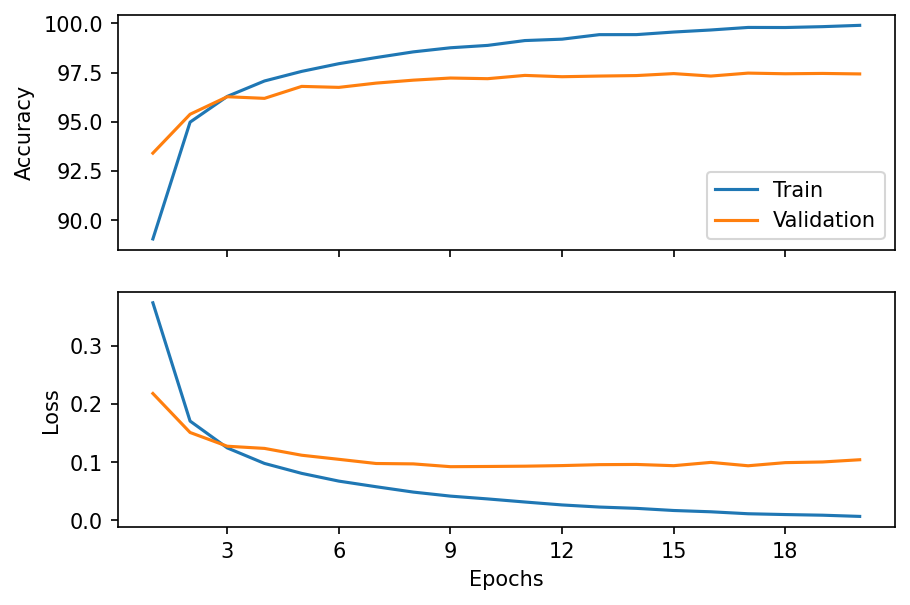

Précision en test: 97.60


In [15]:
net_without_dropout = MnistModel(2, use_dropout=False)
optimizer_without_dropout = optim.SGD(net_without_dropout.parameters(), lr, nesterov=True, momentum=0.9)

history_without_dropout = train(net_without_dropout, optimizer_without_dropout, mnist_train, n_epoch, batch_size, use_gpu=True)
history_without_dropout.display()
print('Précision en test: {:.2f}'.format(test(net_without_dropout, mnist_test, batch_size)))

Réseau avec dropout:

Epoch: 1/20 Step: 750/750 100.00% |█████████████████████████|5.93s loss: 0.579784 acc: 82.112500 val_loss: 0.228847 val_acc: 92.991667
Epoch: 2/20 Step: 750/750 100.00% |█████████████████████████|5.72s loss: 0.302873 acc: 91.020833 val_loss: 0.171631 val_acc: 94.791667
Epoch: 3/20 Step: 750/750 100.00% |█████████████████████████|5.99s loss: 0.244649 acc: 92.610417 val_loss: 0.152701 val_acc: 95.475000
Epoch: 4/20 Step: 750/750 100.00% |█████████████████████████|5.94s loss: 0.213067 acc: 93.702083 val_loss: 0.135048 val_acc: 95.833333
Epoch: 5/20 Step: 750/750 100.00% |█████████████████████████|5.78s loss: 0.189440 acc: 94.383333 val_loss: 0.120713 val_acc: 96.316667
Epoch: 6/20 Step: 750/750 100.00% |█████████████████████████|6.02s loss: 0.174152 acc: 94.854167 val_loss: 0.115719 val_acc: 96.500000
Epoch: 7/20 Step: 750/750 100.00% |█████████████████████████|6.28s loss: 0.163711 acc: 95.095833 val_loss: 0.112694 val_acc: 96.550000
Epoch: 8/20 Step: 750/750 100.00% |████████████████████

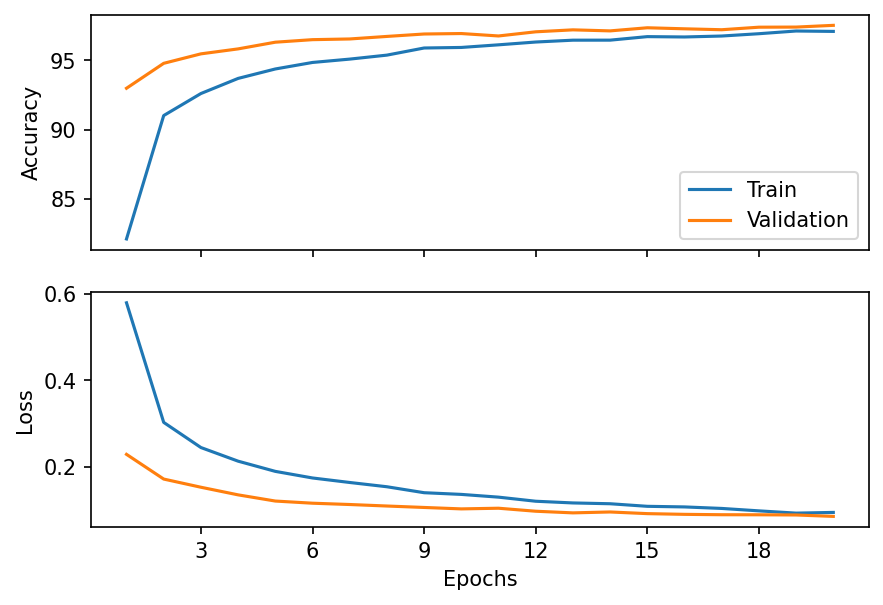

Précision en test: 97.67


In [16]:
net_with_dropout = MnistModel(2, use_dropout=True, dropout_p=0.3)
optimizer_with_dropout = optim.SGD(net_with_dropout.parameters(), lr, nesterov=True, momentum=0.9)

history_with_dropout = train(net_with_dropout, optimizer_with_dropout, mnist_train, n_epoch, batch_size, use_gpu=True)
history_with_dropout.display()
print('Précision en test: {:.2f}'.format(test(net_with_dropout, mnist_test, batch_size)))

#### Questions
- Quel est l'effet du dropout sur l'entraînement du réseau? 

    **Sans dropout, le réseau a des performances en entraînement qui s'éloignent des performances en validation plus on avance dans les époques, c'est-à-dire du surapprentissage. À l'opposé, avec le dropout le réseau à des performances en entraînement proches des performances en validation tout au long des époques, avec même des résultats légèrement meilleurs en validation dans notre cas. Il est important de noter que le dropout a une influence différente en mode entraînement et en mode évaluation, par conséquent les performances en entraînement pourraient être supérieures si on évalue le réseau en mode évaluation pour les données d'entraînement.**
    
- Essayez plusieurs valeurs de dropout et observez les effets.

    **Avec des valeurs de dropout trop faibles (0.01), il n'y a pas vraiment d'effets sur l'apprentissage du réseau. Avec des valeurs de dropout trop élevées (0.9), le réseau a de la difficulté à apprendre.**